<h1><font color="#113D68" size=6>TINTOlib: Converting Tidy Data into Synthetic Images</font></h1>

<h1><font color="#113D68" size=5>Template problem with a Vision Transformer (ViT)</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
<font color="#113D68" size=3>Raúl García-Castro</font><br>
<font color="#113D68" size=3>Jiayun Liu</font><br>
</div>


---

In [1]:
import gc
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import tifffile as tifi
import keras
from keras.utils import plot_model
from keras import ops
from PIL import Image
from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

# TensorFlow and Keras
from keras import layers, models, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (Activation, BatchNormalization, concatenate,
                                     Conv2D, Dense, Dropout, Flatten, Input,
                                     LayerNormalization, MaxPool2D, MaxPooling2D)
from keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adadelta, Adam, Adamax, SGD, AdamW

#Models of TINTOlib
from TINTOlib.barGraph import BarGraph
from TINTOlib.combination import Combination
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.supertml import SuperTML
from TINTOlib.tinto import TINTO
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

# SET RANDOM SEED FOR REPRODUCIBILITY
SEED = 64
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

# Mover CATEGORIA al final
cols = [c for c in df.columns if c != "CATEGORIA"] + ["CATEGORIA"]
df = df[cols]

# Quitar columnas no predictoras (lon/lat/year) si no las quieres en la imagen
drop_cols = ["lon", "lat", "year"]
df = df[[c for c in df.columns if c not in drop_cols or c == "CATEGORIA"]]

# Remapear categorías a consecutivas 0..K-1
clases_unicas = sorted(df["CATEGORIA"].unique())
mapa = {old: new for new, old in enumerate(clases_unicas)}
df["CATEGORIA"] = df["CATEGORIA"].map(mapa)

#Read CSV
df.head(2)

In [3]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [4]:
#Select the model and the parameters
problem_type = "supervised"
#problem_type = "regression"
pixelTML = 30
pixel = 40
## zoom para ampliar la imagen
image_model = REFINED(problem=problem_type, random_seed=SEED, zoom=2, n_processors=8)
image_model = IGTD(problem= problem_type, random_seed=SEED, scale=[4,4], zoom=2)

#Define the dataset path and the folder where the images will be saved
results_folder = "IGTD"
images_folder = "IGTD"

In [5]:
import os

# Generate the images if the folder does not exist
if not os.path.exists(images_folder):
    #Generate thet images
    image_model.fit_transform(df, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

IGTD\supervised.csv


In [6]:
imgs = pd.read_csv(img_paths)

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]

In [ ]:
imgs = imgs.rename(columns={'class': 'values'})

combined_dataset = pd.concat([imgs,df],axis=1)
combined_dataset
# Drop target column and values which is a copy of target column
df_x = combined_dataset.drop(df.columns[-1],axis=1).drop("values",axis=1)
df_y = combined_dataset["values"]

df_x

In [8]:
import cv2
from sklearn.preprocessing import MinMaxScaler
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.20, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)

#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
"""X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])"""

# For 1 channels (GRAY SCALE)
X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale numerical data
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

attributes = X_train_num.shape[1]
height, width = X_train_img[0].shape
channels = 1
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (8, 8, 1)
Attributres:  13
Image size (pixels): 8


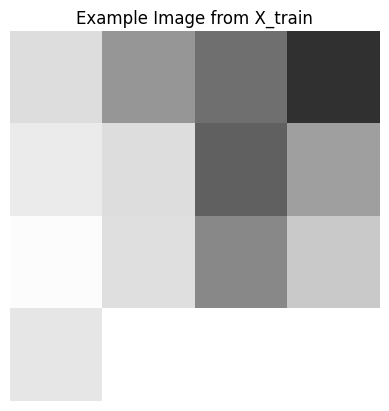

In [9]:
# Plot an example image (e.g., the first image in the array)
example_image = X_train_img[0]

# Convert the image from BGR (OpenCV default) to RGB for correct color display
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(example_image_rgb)
plt.title("Example Image from X_train")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

In [10]:
X_train_img = X_train_img/255
X_val_img = X_val_img/255
X_test_img = X_test_img/255

In [11]:
image_size = pixel
patch_size = 2
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 2
mlp_head_units = [
    64,
    32,
]

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
def create_vit_classifier(patch_size, projection_dim, num_heads, transformer_layers, mlp_head_units):
    inputs = keras.Input(shape=imgs_shape)
    patches = Patches(patch_size)(inputs)
    num_patches = (imgs_shape[0] // patch_size) ** 2
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    model = keras.Model(inputs=inputs, outputs=features)
    return model

ViT IGTD: patch_size=2, projection_dim=32, num_heads=2, transformer_layers=2
Restoring model weights from the end of the best epoch: 48.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


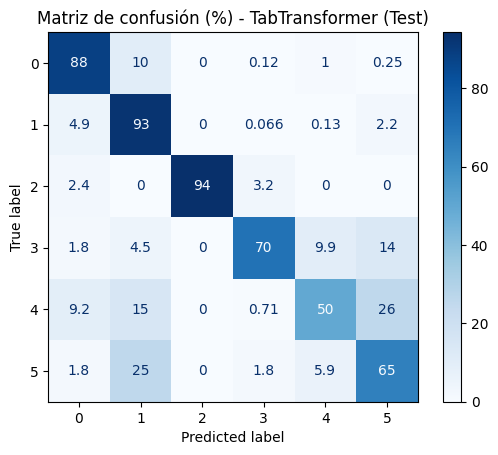

Val -> loss=0.4261 | val_acc=0.8503 | OA=0.8655 | Prec(macro)=0.8245 | Recall(macro)=0.7672 | F1-macro=0.7918
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=32, num_heads=2, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


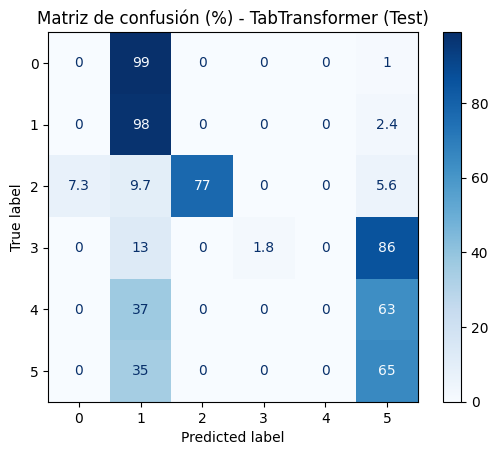

Val -> loss=0.5068 | val_acc=0.8274 | OA=0.5916 | Prec(macro)=0.4981 | Recall(macro)=0.4031 | F1-macro=0.3563
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=32, num_heads=2, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


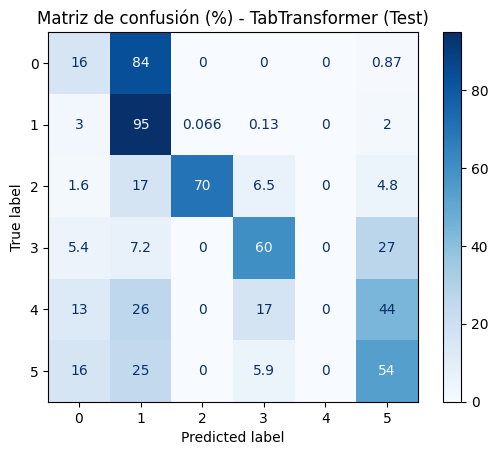

Val -> loss=0.5181 | val_acc=0.8308 | OA=0.6303 | Prec(macro)=0.5381 | Recall(macro)=0.4909 | F1-macro=0.4875
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=32, num_heads=4, transformer_layers=2
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


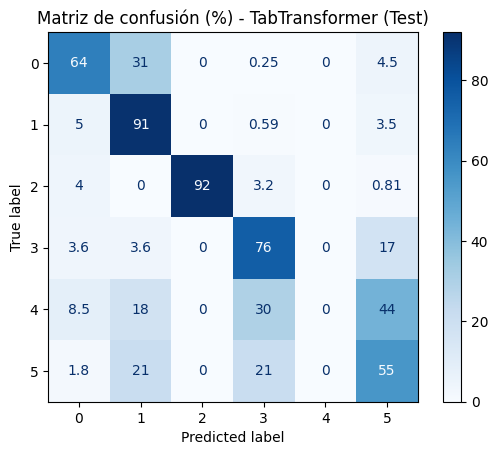

Val -> loss=0.4984 | val_acc=0.8312 | OA=0.7590 | Prec(macro)=0.5845 | Recall(macro)=0.6297 | F1-macro=0.5959
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=32, num_heads=4, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


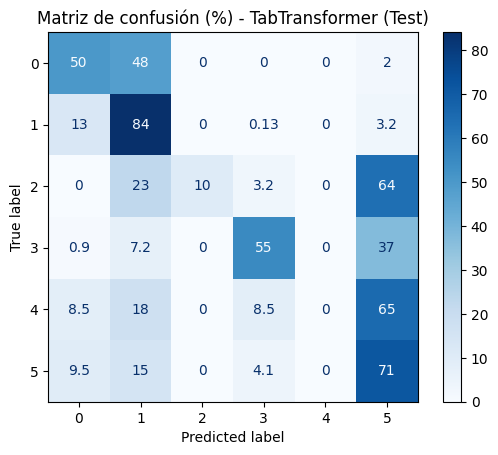

Val -> loss=0.5046 | val_acc=0.8247 | OA=0.6559 | Prec(macro)=0.5711 | Recall(macro)=0.4520 | F1-macro=0.4381
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=32, num_heads=4, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


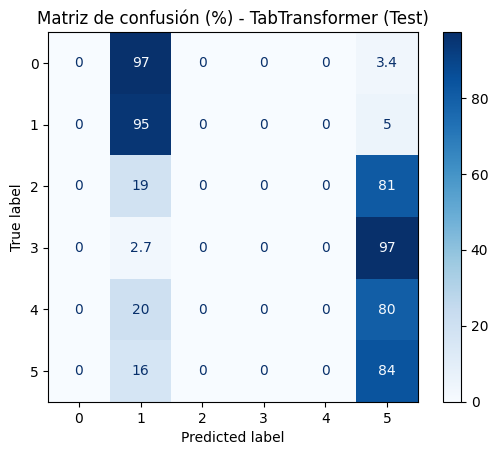

Val -> loss=0.4961 | val_acc=0.8322 | OA=0.5584 | Prec(macro)=0.1547 | Recall(macro)=0.2977 | F1-macro=0.1998
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=32, num_heads=6, transformer_layers=2
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


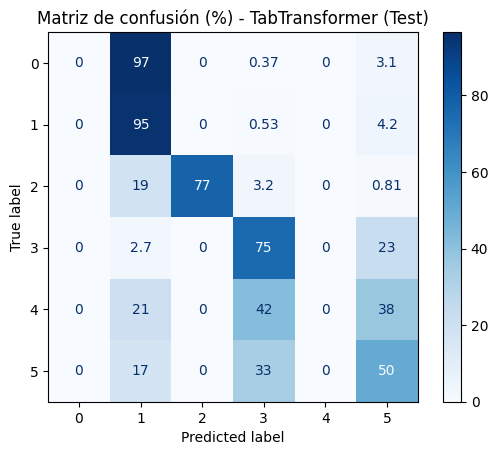

Val -> loss=0.4923 | val_acc=0.8325 | OA=0.5957 | Prec(macro)=0.3971 | Recall(macro)=0.4958 | F1-macro=0.4262
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=32, num_heads=6, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


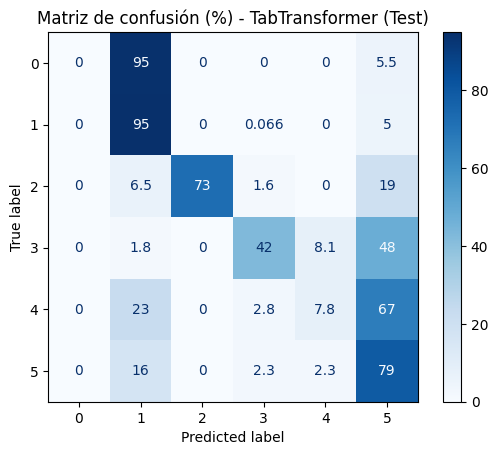

Val -> loss=0.5182 | val_acc=0.8123 | OA=0.6053 | Prec(macro)=0.5407 | Recall(macro)=0.4946 | F1-macro=0.4658
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=32, num_heads=6, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


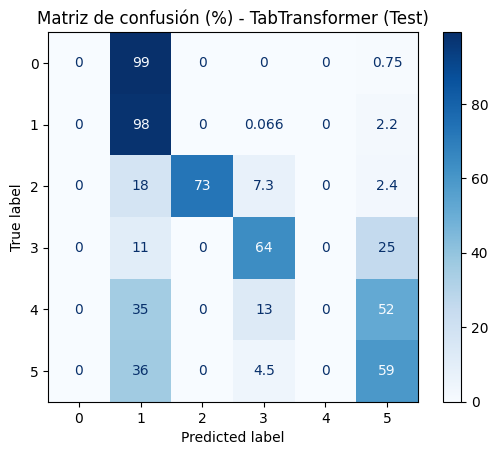

Val -> loss=0.4863 | val_acc=0.8339 | OA=0.6090 | Prec(macro)=0.4556 | Recall(macro)=0.4889 | F1-macro=0.4604
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=2, transformer_layers=2
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


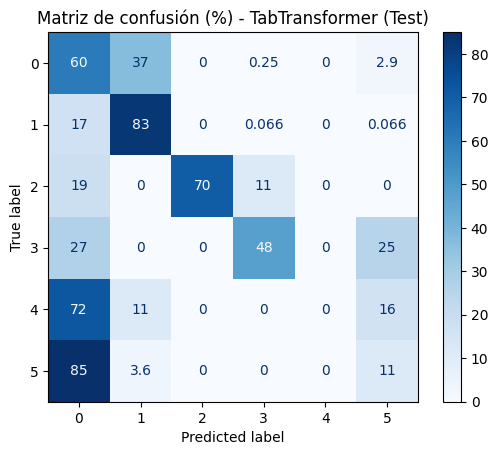

Val -> loss=0.5136 | val_acc=0.8188 | OA=0.6532 | Prec(macro)=0.5418 | Recall(macro)=0.4538 | F1-macro=0.4819
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=2, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


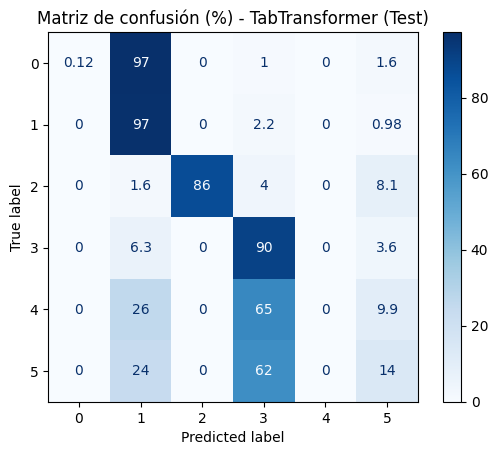

Val -> loss=0.5365 | val_acc=0.8202 | OA=0.5864 | Prec(macro)=0.5417 | Recall(macro)=0.4790 | F1-macro=0.3839
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=2, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


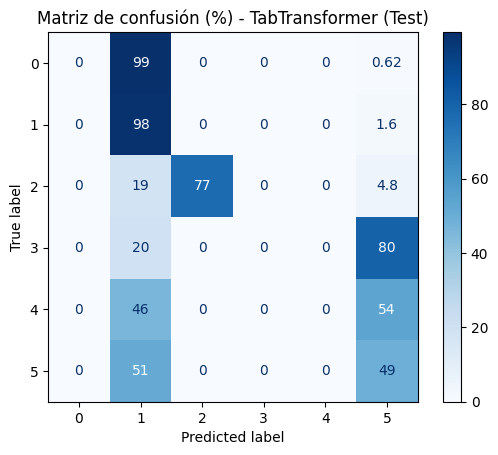

Val -> loss=0.5246 | val_acc=0.8243 | OA=0.5827 | Prec(macro)=0.3243 | Recall(macro)=0.3735 | F1-macro=0.3364
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=4, transformer_layers=2
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


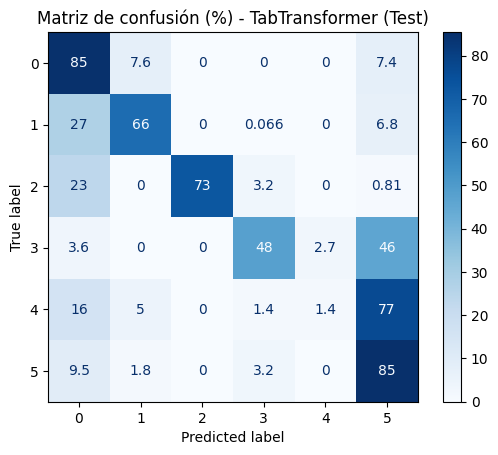

Val -> loss=0.5054 | val_acc=0.8349 | OA=0.6902 | Prec(macro)=0.6787 | Recall(macro)=0.5966 | F1-macro=0.5733
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=4, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


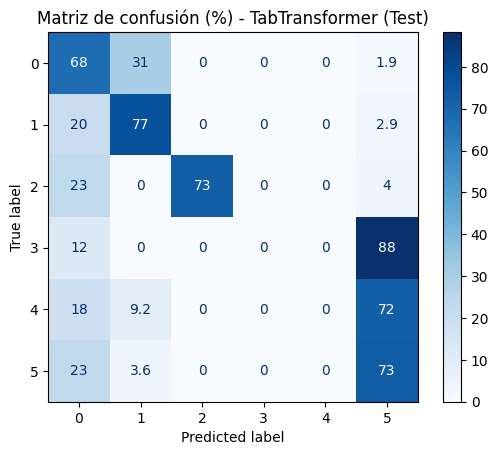

Val -> loss=0.4983 | val_acc=0.8312 | OA=0.6734 | Prec(macro)=0.4592 | Recall(macro)=0.4840 | F1-macro=0.4577
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=4, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


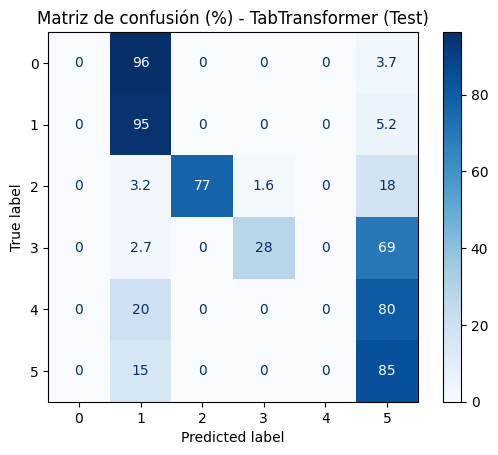

Val -> loss=0.5187 | val_acc=0.8195 | OA=0.6015 | Prec(macro)=0.4897 | Recall(macro)=0.4745 | F1-macro=0.4289
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=6, transformer_layers=2
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


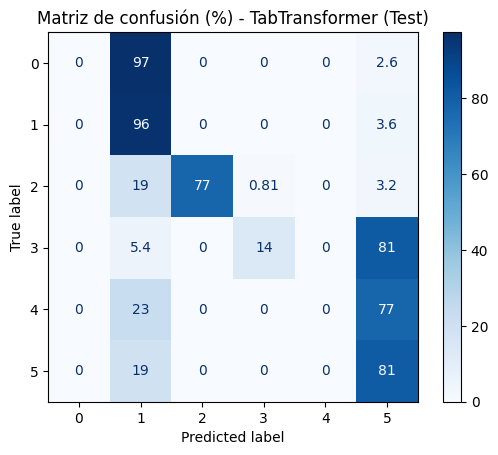

Val -> loss=0.5322 | val_acc=0.8202 | OA=0.6015 | Prec(macro)=0.4919 | Recall(macro)=0.4471 | F1-macro=0.3987
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=6, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


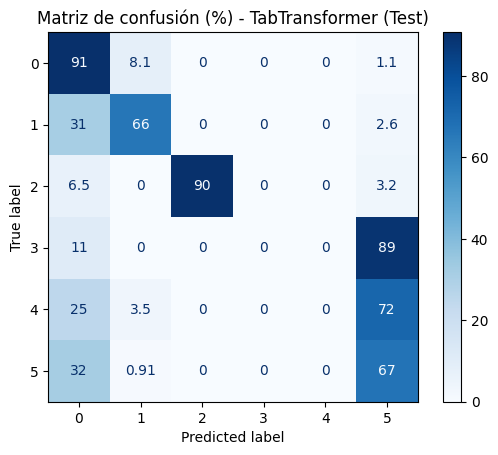

Val -> loss=0.4965 | val_acc=0.8315 | OA=0.6826 | Prec(macro)=0.4749 | Recall(macro)=0.5240 | F1-macro=0.4804
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=64, num_heads=6, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


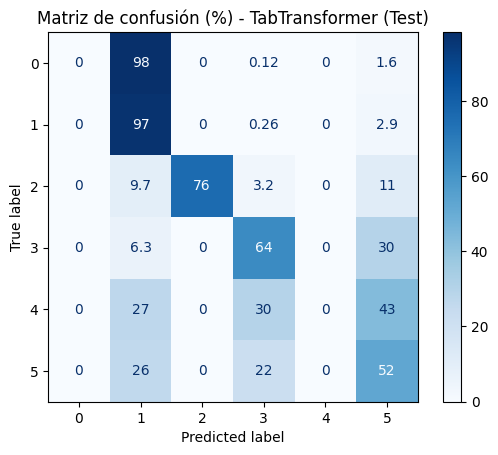

Val -> loss=0.5236 | val_acc=0.8199 | OA=0.6008 | Prec(macro)=0.4081 | Recall(macro)=0.4815 | F1-macro=0.4307
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=2, transformer_layers=2
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


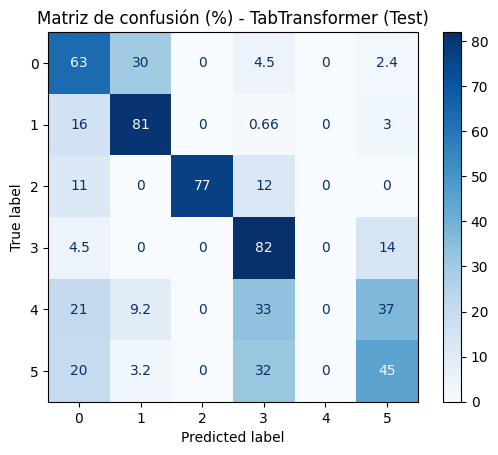

Val -> loss=0.5906 | val_acc=0.7962 | OA=0.6912 | Prec(macro)=0.5325 | Recall(macro)=0.5784 | F1-macro=0.5361
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=2, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


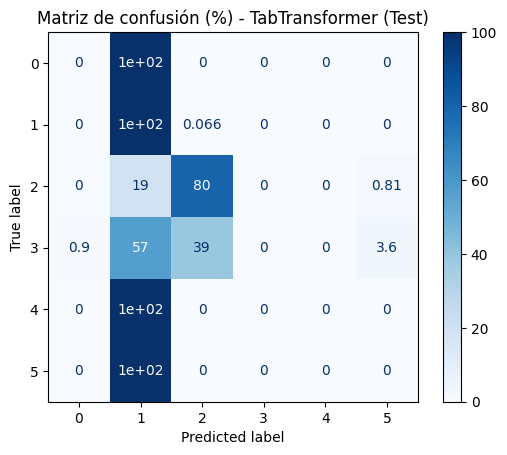

Val -> loss=0.5755 | val_acc=0.8038 | OA=0.5549 | Prec(macro)=0.2069 | Recall(macro)=0.2996 | F1-macro=0.2417
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=2, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


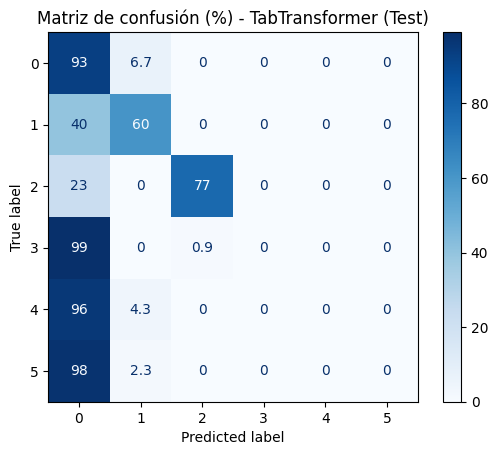

Val -> loss=0.5634 | val_acc=0.8096 | OA=0.6039 | Prec(macro)=0.3884 | Recall(macro)=0.3852 | F1-macro=0.3615
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=4, transformer_layers=2
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


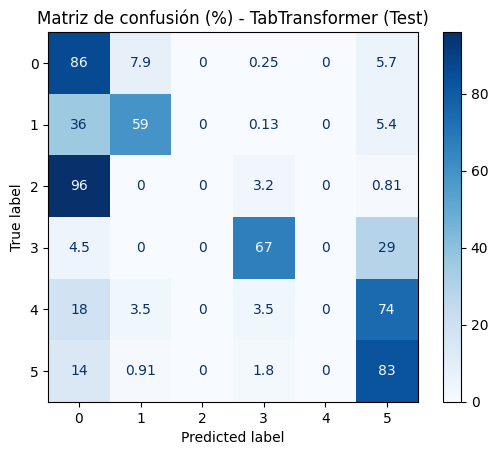

Val -> loss=0.5939 | val_acc=0.8041 | OA=0.6306 | Prec(macro)=0.4392 | Recall(macro)=0.4912 | F1-macro=0.4368
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=4, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


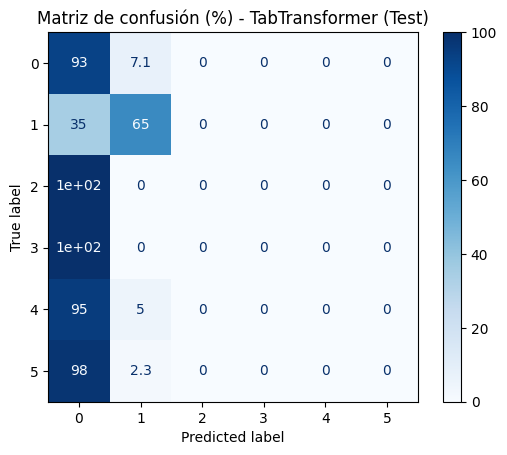

Val -> loss=0.5084 | val_acc=0.8308 | OA=0.5953 | Prec(macro)=0.2227 | Recall(macro)=0.2636 | F1-macro=0.2215
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=4, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


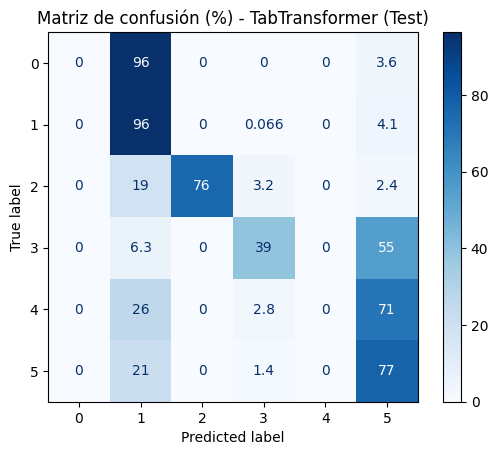

Val -> loss=0.5564 | val_acc=0.8243 | OA=0.6046 | Prec(macro)=0.4671 | Recall(macro)=0.4794 | F1-macro=0.4435
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=6, transformer_layers=2
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


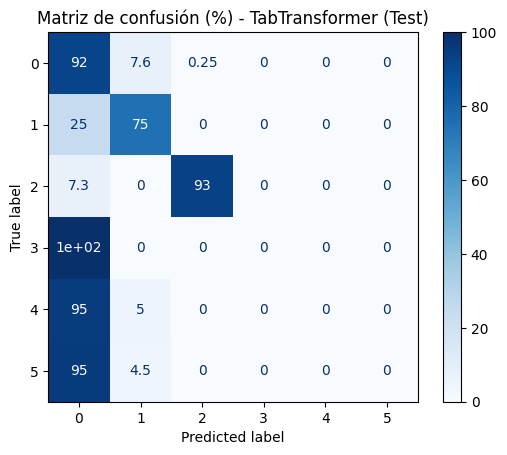

Val -> loss=0.5776 | val_acc=0.8158 | OA=0.6850 | Prec(macro)=0.3979 | Recall(macro)=0.4337 | F1-macro=0.4016
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=6, transformer_layers=4
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


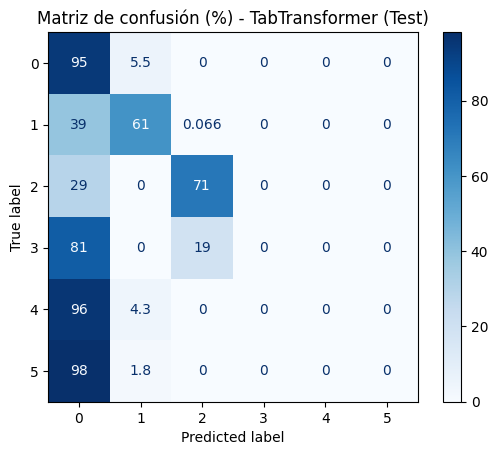

Val -> loss=0.5372 | val_acc=0.8192 | OA=0.6073 | Prec(macro)=0.3599 | Recall(macro)=0.3774 | F1-macro=0.3449
--------------------------------------------------------------------------------
ViT IGTD: patch_size=2, projection_dim=128, num_heads=6, transformer_layers=6
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


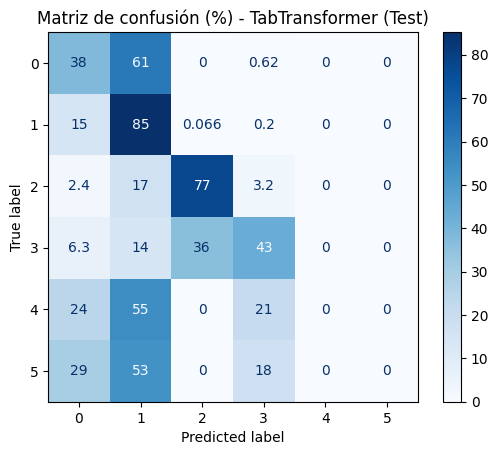

Val -> loss=0.6851 | val_acc=0.7339 | OA=0.5988 | Prec(macro)=0.3664 | Recall(macro)=0.4069 | F1-macro=0.3826
--------------------------------------------------------------------------------


OSError: Cannot save file into a non-existent directory: 'Resultados'

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, Dense, Dropout
import itertools
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# EarlyStopping
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Métricas
METRICS = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
]

# Definición del modelo ViT puro
def create_vit_model(patch_size, projection_dim, num_heads, transformer_layers, mlp_head_units):
    inputs = keras.Input(shape=imgs_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder((pixel // patch_size) ** 2, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    output = Dense(7, activation='softmax')(features)
    model = Model(inputs=inputs, outputs=output)
    return model

################# AQUÍ LOS HIPERPARÁMETROS!!! #######
################# ViT IGTD: patch_size=2, projection_dim=32, num_heads=2, transformer_layers=2 #################
# Parámetros para grid search
patch_sizes = [2]
projection_dims = [32, 64, 128]
num_heads_list = [2, 4, 6]
transformer_layers_list = [2, 4, 6]

results = []

# Bucle de combinaciones
for patch_size, projection_dim, num_heads, transformer_layers in itertools.product(
        patch_sizes, projection_dims, num_heads_list, transformer_layers_list):

    print(f"ViT IGTD: patch_size={patch_size}, projection_dim={projection_dim}, num_heads={num_heads}, transformer_layers={transformer_layers}")

    model = create_vit_model(patch_size, projection_dim, num_heads, transformer_layers, [128, 64])
    opt = AdamW()
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=METRICS
    )

    history = model.fit(
        x=X_train_img,
        y=y_train,
        validation_data=(X_val_img, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopper],
        verbose=0
    )

    y_pred_probs = model.predict(X_test_img)
    y_pred = y_pred_probs.argmax(axis=1).astype("int32")
    oa = accuracy_score(y_test, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    cm = confusion_matrix(y_test, y_pred)
    cm_row_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_row_percentage = np.nan_to_num(cm_row_percentage)  # handle division by zero

    ConfusionMatrixDisplay(cm_row_percentage).plot(cmap='Blues')
    plt.title("Matriz de confusión (%) - TabTransformer (Test)")
    plt.show()

    final_metrics = {
        "val_loss":      history.history.get("val_loss",      [-1])[-1],
        "val_accuracy":  history.history.get("val_accuracy",  [-1])[-1],
        # si NO compilaste con esas métricas, no existirán en history:
        # "val_auc":       history.history.get("val_auc",       [-1])[-1],
        # "val_precision": history.history.get("val_precision", [-1])[-1],
        # "val_recall":    history.history.get("val_recall",    [-1])[-1],
        "OA":            float(oa),
        "precision_macro": float(prec_macro),
        "recall_macro":    float(rec_macro),
        "f1_macro":        float(f1_macro),
        "confusion_matrix": cm.tolist(),   # serializable a JSON/CSV
    }

    scores = model.evaluate(X_test_img, y_test, verbose=0)
    score_dict = {metric.name: score for metric, score in zip(model.metrics, scores)}

    result = {
        "patch_size": patch_size,
        "projection_dim": projection_dim,
        "num_heads": num_heads,
        "transformer_layers": transformer_layers,
        **score_dict,
        **final_metrics
    }
    results.append(result)

    print(
    f"Val -> loss={final_metrics['val_loss']:.4f} | "
    f"val_acc={final_metrics['val_accuracy']:.4f} | "
    f"OA={final_metrics['OA']:.4f} | "
    f"Prec(macro)={final_metrics['precision_macro']:.4f} | "
    f"Recall(macro)={final_metrics['recall_macro']:.4f} | "
    f"F1-macro={final_metrics['f1_macro']:.4f}"
    )
    print("-"*80)

In [21]:
# Guardar CSV
results_df = pd.DataFrame(results)
results_df.to_csv("Resultados/IGTD_ViT.csv", index=False)
print("Resultados guardados en Resultados/IGTD_ViT.csv")

Resultados guardados en Resultados/IGTD_ViT.csv
